In [1]:
from openai import OpenAI
import json
from dotenv import load_dotenv

load_dotenv()


client = OpenAI()

def suggest_new_params(
    optimize_direction: str = "minimize",      # "maximize" or "minimize"
    history: list | None = None,         # list of {"params": ..., "metric": ...}
    constraints_text: str = "",   # free-text constraints
    model_meta: dict | None = None,      # <-- новая мета-информация о модели
    model_name: str = "gpt-5.1"
):
    """
    Version with user-defined textual constraints and model meta information.
    """

    history_text = json.dumps(history, ensure_ascii=False) if history else "[]"
    meta_text = json.dumps(model_meta, ensure_ascii=False) if model_meta else "{}"

    example_input = {
        "current_params": {"learning_rate": 0.01, "depth": 6, "n_estimators": 1000},
        "metric": 0.15,
        "optimize_direction": "minimize",
        "constraints": "learning_rate between 0.001 and 0.1; depth integer 1-12; n_estimators < 5000",
        "model_meta": {"general": {"task": "regression", "dataset_size": 5000}}
    }
    example_output = {
        "learning_rate": 0.008,
        "depth": 7,
        "n_estimators": 1200
    }

    prompt = f"""
You are an ML hyperparameter optimization expert.

Optimization direction: {optimize_direction}
Search history: {history_text}

Model meta-information (may describe either a classical ML model or a neural network):
{meta_text}

User-defined constraints:
{constraints_text}

Example of input and output:

Input:
{json.dumps(example_input, indent=2)}
Output (JSON only):
{json.dumps(example_output, indent=2)}

Requirements:
1. Use the meta-information strictly and interpret it correctly depending on model type.
2. Apply all constraints strictly.
3. Suggest new hyperparameters that can improve the metric.
4. Return ONLY a valid JSON object with no other text.
5. Ensure JSON is syntactically correct.
"""


    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are an AutoML and hyperparameter tuning expert."},
            {"role": "user",  "content": prompt},
        ],
        temperature=0.2,
    )

    raw = response.choices[0].message.content

    try:
        return json.loads(raw)
    except json.JSONDecodeError:
        return json.loads(raw[raw.find("{"): raw.rfind("}") + 1])

In [2]:
direction = "minimize"
history = [
    {"params": {'input_size': 96, 'hidden_size': 512, 'n_head': 8, 'dropout': 0.05, 'conv_hidden_size': 32, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}, "metric": 0.95},
    {"params": {'input_size': 96, 'hidden_size': 512, 'n_head': 8, 'dropout': 0.1, 'conv_hidden_size': 64, 'distil': False, 'activation': 'relu', 'encoder_layers': 4, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}, "metric": 0.96}
]

constraints = """
{
    "input_size": trial.suggest_categorical("input_size", [horizon]),
    "hidden_size": trial.suggest_categorical("hidden_size", [64, 128, 256, 512]),
    "n_head": trial.suggest_categorical("n_head", [4, 8, 16]),
    "dropout": trial.suggest_categorical("dropout", [0, 0.05, 0.1, 0.2, 0.5]),
    "conv_hidden_size": trial.suggest_categorical(
        "conv_hidden_size", [16, 32, 64, 128]
    ),
    "distil": trial.suggest_categorical("distil", [True, False]),
    "activation": trial.suggest_categorical("activation", ["relu", "gelu"]),
    "encoder_layers": trial.suggest_categorical("encoder_layers", [2, 3, 4, 6]),
    "decoder_layers": trial.suggest_categorical("decoder_layers", [2]),
    "learning_rate": trial.suggest_categorical("learning_rate", [1e-4]),
    "scaler_type": trial.suggest_categorical("scaler_type", ["robust"]),
    "max_steps": trial.suggest_categorical("max_steps", [8]),
    "batch_size": trial.suggest_categorical("batch_size", [32]),
    "windows_batch_size": trial.suggest_categorical("windows_batch_size", [1024]),
    "random_seed": trial.suggest_categorical("random_seed", [1]),
}
"""

model_meta = {
    "general": {
        "task": "time_series_forecasting",
        "dataset_size": 50000
    },
    "neural": {
        "architecture": "Informer",
    },
    "resource_limits": {
        "gpu": True,
        "max_training_time_minutes": 5
    }
}

new_params = suggest_new_params(
    model_meta=model_meta,
    optimize_direction=direction,
    history=history,
    constraints_text=constraints,
    model_name="openrouter/sherlock-think-alpha",
)

print("Suggested new parameters:")
print(new_params)

Suggested new parameters:
{'input_size': 96, 'hidden_size': 512, 'n_head': 16, 'dropout': 0, 'conv_hidden_size': 32, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}


In [3]:
from datasetsforecast.long_horizon2 import LongHorizon2, ETTh1
import pandas as pd

In [4]:
Y_df = LongHorizon2.load(directory="data", group="ETTh1")
Y_df["ds"] = pd.to_datetime(Y_df["ds"])

n_time = len(Y_df.ds.unique())
val_size = int(0.2 * n_time)
test_size = int(0.2 * n_time)

Y_df

,index,ds,unique_id,y
0,0,2016-07-01 00:00:00,HUFL,-0.279827
1,1,2016-07-01 01:00:00,HUFL,-0.301290
2,2,2016-07-01 02:00:00,HUFL,-0.387142
3,3,2016-07-01 03:00:00,HUFL,-0.397873
4,4,2016-07-01 04:00:00,HUFL,-0.354948
...,...,...,...,...
100795,118915,2018-02-20 19:00:00,OT,-2.003877
100796,118916,2018-02-20 20:00:00,OT,-2.003877
100797,118917,2018-02-20 21:00:00,OT,-1.776565
100798,118918,2018-02-20 22:00:00,OT,-1.742809


In [5]:
from neuralforecast import NeuralForecast
from neuralforecast.auto import Informer
from neuralforecast.losses.pytorch import MSE
from neuralforecast.losses.numpy import mse
import torch


In [ ]:
torch.set_float32_matmul_precision("high")

horizon = ETTh1.horizons[0]
n_trials = 25
optimize_direction = "minimize"


history = []

constraints_text = f"""
{{
    "input_size": trial.suggest_categorical("input_size", [{horizon}]),
    "hidden_size": trial.suggest_categorical("hidden_size", [64, 128, 256, 512]),
    "n_head": trial.suggest_categorical("n_head", [4, 8, 16]),
    "dropout": trial.suggest_categorical("dropout", [0, 0.05, 0.1, 0.2, 0.5]),
    "conv_hidden_size": trial.suggest_categorical(
        "conv_hidden_size", [16, 32, 64, 128]
    ),
    "distil": trial.suggest_categorical("distil", [True, False]),
    "activation": trial.suggest_categorical("activation", ["relu", "gelu"]),
    "encoder_layers": trial.suggest_categorical("encoder_layers", [2, 3, 4, 6]),
    "decoder_layers": trial.suggest_categorical("decoder_layers", [2]),
    "learning_rate": trial.suggest_categorical("learning_rate", [1e-4]),
    "scaler_type": trial.suggest_categorical("scaler_type", ["robust"]),
    "max_steps": trial.suggest_categorical("max_steps", [8]),
    "batch_size": trial.suggest_categorical("batch_size", [32]),
    "windows_batch_size": trial.suggest_categorical("windows_batch_size", [1024]),
    "random_seed": trial.suggest_categorical("random_seed", [1]),
}}
"""

model_meta = {
    "general": {
        "task": "time_series_forecasting",
        "dataset_size": len(Y_df),
        "series_count": Y_df['unique_id'].nunique()
    },
    "neural": {
        "architecture": "Informer",
        "sequence_length": horizon
    },
    "resource_limits": {
        "gpu": True,
        "max_training_time_minutes": 30
    }
}

best_metric = float("inf")
best_params = None

for trial in range(n_trials):
    print(f"=== Trial {trial + 1} ===")
    
    # Suggest new hyperparameters
    new_params = suggest_new_params(
        optimize_direction=optimize_direction,
        history=history,
        constraints_text=constraints_text,
        model_meta=model_meta,
        model_name="tngtech/deepseek-r1t2-chimera:free",
    )

    
    # Train Informer with suggested parameters
    nf = NeuralForecast(
        models=[Informer(h=horizon, loss=MSE(), **new_params)],
        freq="h"
    )
    Y_hat_df = nf.cross_validation(
        df=Y_df, val_size=val_size, test_size=test_size, n_windows=None
    )
    
    metric_value = nf.models[0].metrics["ptl/val_loss"].item()
    
    print(f"Trial {trial + 1} finished with value: {metric_value:.4f} and parameters: {new_params}")
    
    # Update best if improved
    if metric_value < best_metric:
        best_metric = metric_value
        best_params = new_params
    
    # Append to history
    history.append({"params": new_params, "metric": metric_value})

print("=== Best hyperparameters after 25 trials ===")
print(best_params)
print(f"Best metric: {best_metric:.4f}")


/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


=== Trial 1 ===


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_em

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 1 finished with value: 0.9689 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 8, 'dropout': 0.1, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 4, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}
=== Trial 2 ===


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_em

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 2 finished with value: 0.7979 and parameters: {'input_size': 96, 'hidden_size': 512, 'n_head': 16, 'dropout': 0.2, 'conv_hidden_size': 128, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}
=== Trial 3 ===


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_em

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 3 finished with value: 0.9978 and parameters: {'input_size': 96, 'hidden_size': 128, 'n_head': 8, 'dropout': 0.1, 'conv_hidden_size': 32, 'distil': True, 'activation': 'relu', 'encoder_layers': 3, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}
=== Trial 4 ===


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_em

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 4 finished with value: 0.9687 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 8, 'dropout': 0.1, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 4, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}
=== Trial 5 ===


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_em

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 5 finished with value: 1.0722 and parameters: {'input_size': 96, 'hidden_size': 64, 'n_head': 8, 'dropout': 0.05, 'conv_hidden_size': 16, 'distil': True, 'activation': 'relu', 'encoder_layers': 2, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}
=== Trial 6 ===


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_em

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 6 finished with value: 0.7916 and parameters: {'input_size': 96, 'hidden_size': 512, 'n_head': 16, 'dropout': 0.1, 'conv_hidden_size': 128, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}
=== Trial 7 ===


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_em

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 7 finished with value: 0.8434 and parameters: {'input_size': 96, 'hidden_size': 512, 'n_head': 16, 'dropout': 0.1, 'conv_hidden_size': 128, 'distil': True, 'activation': 'gelu', 'encoder_layers': 4, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}
=== Trial 8 ===


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


In [11]:
best_params

{'input_size': 96,
 'hidden_size': 256,
 'n_head': 8,
 'dropout': 0.1,
 'conv_hidden_size': 64,
 'distil': True,
 'activation': 'gelu',
 'encoder_layers': 3,
 'decoder_layers': 2,
 'learning_rate': 0.0001,
 'scaler_type': 'robust',
 'max_steps': 8,
 'batch_size': 32,
 'windows_batch_size': 1024,
 'random_seed': 1}

In [12]:
nf = NeuralForecast(
    models=[Informer(h=horizon, loss=MSE(), **best_params)],
    freq="h"
)
Y_hat_df = nf.cross_validation(
    df=Y_df, val_size=val_size, test_size=test_size, n_windows=None
)

INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MSE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 768    | train
4 | dec_embedding | DataEmbedding | 768    | train
5 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_33138/3558308939.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_plot = Y_plot[Y_hat_df["cutoff"].isin(cutoffs)]


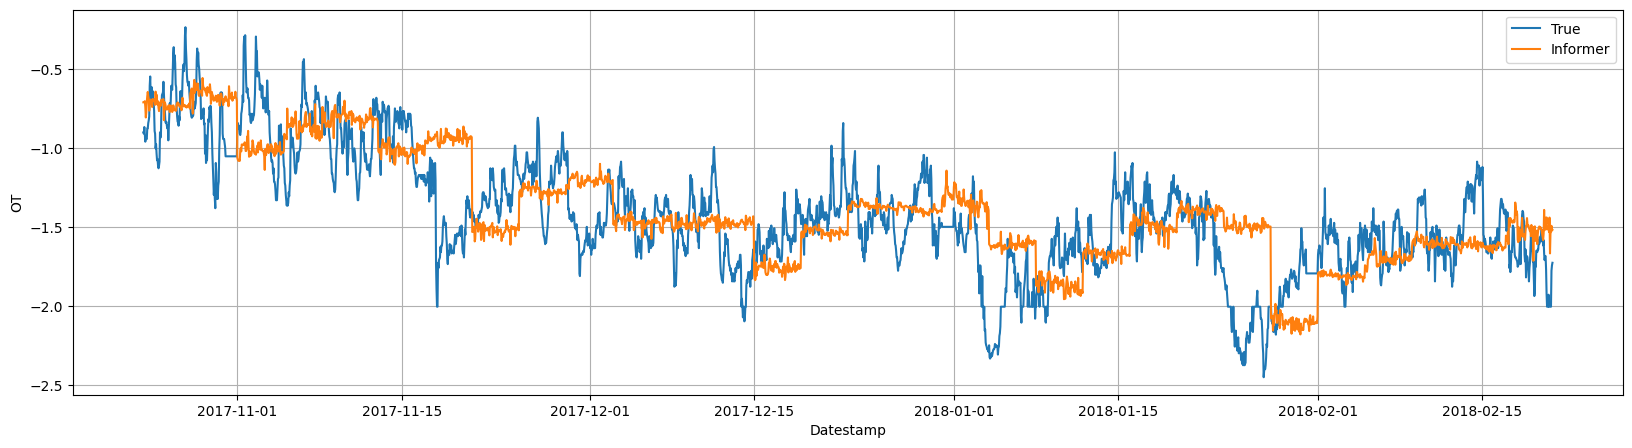

In [15]:
import matplotlib.pyplot as plt

Y_plot = Y_hat_df[Y_hat_df["unique_id"] == "OT"]  # OT dataset
cutoffs = Y_hat_df["cutoff"].unique()[::horizon]
Y_plot = Y_plot[Y_hat_df["cutoff"].isin(cutoffs)]

plt.figure(figsize=(20, 5))
plt.plot(Y_plot["ds"], Y_plot["y"], label="True")
plt.plot(Y_plot["ds"], Y_plot["Informer"], label="Informer")
plt.xlabel("Datestamp")
plt.ylabel("OT")
plt.grid()
plt.legend();

In [17]:
mse_informer = mse(Y_hat_df["y"], Y_hat_df["Informer"])

print(f"Informer: {mse_informer:.3f}")

Informer: 0.607
